# lifetime time calibration checks - read the maps and check the calibration
### JAH 4/8/18

<i>
This NB shows the energy distribution and compute the resolution after corrections. 

It shows the energy vs X, Y, Z, R, T variables, to check for possible bias. 

It shows the energy resolution in a XY plane for different z-slices to check for bias.

It makes a movie of the geometry and energy resolution vs z-slices (it need a plot folder and the imageio module)
</i>

In [1]:
import time
print("Last updated on ", time.asctime())

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

### Notebook configuration

In [3]:
run_number                 = 6804
input_dst_filenames        = [f"$IC_DATA/{run_number}/kdsts/kdst_{run_number}_filtered.h5"]
run_number_correction      = run_number
correction_filename        = f"$IC_DATA/maps/kr_corrections_run{run_number_correction}.h5"

make_movie = False

Rrange  =    0., 200.
Zrange  =    0., 550.
XYrange = -200., 200.
E0range = 7.5e3, 13.5e3

Rfidrange  =    0., 150.
Zfidrange  =    0., 250.

XYnbins = 80

### Imports

In [4]:
import os
import time
import datetime

import tables            as tb
import numpy             as np
import matplotlib.pyplot as plt

import invisible_cities.core.fit_functions as fitf

from  invisible_cities.core .core_functions import in_range

from krcal.dev.table_info import RunInfo
from krcal.dev.table_info import MapInfo

import krcal.utils.hst_extend_functions as hst
import krcal.dev.akr_functions          as akr
import krcal.utils.plt_functions        as apt
import krcal.utils.kdst_functions       as kdstf
import krcal.dev.corrections            as corrections

#import krcal.utils.movie_functions      as mv

In [5]:
# Plotting style
default_cmap = "jet"
figure_size  = 10, 8
font_size    = 14

plt.rcParams["figure.figsize"] =   figure_size
plt.rcParams[  "font.size"   ] =   font_size

### Initialization

In [6]:
input_dst_filenames = [os.path.expandvars(fi) for fi in input_dst_filenames]
correction_filename =  os.path.expandvars(correction_filename)

In [7]:
dst = kdstf.load_dsts(input_dst_filenames, "DST", "Events")

## Read data

In [8]:
unique_events = ~dst.event.duplicated()

number_of_S2s_full  = np.size         (unique_events)
number_of_evts_full = np.count_nonzero(unique_events)

print(f"Total number of S2s   : {number_of_S2s_full} ")
print(f"Total number of events: {number_of_evts_full}")

Total number of S2s   : 82532 
Total number of events: 82532


## Relevant data and corrections

In [9]:
X   = dst.X   .values
Y   = dst.Y   .values
Z   = dst.Z   .values
R   = dst.R   .values
Phi = dst.Phi .values
S2e = dst.S2e .values
S2q = dst.S2q .values
T   = dst.time.values
TD  = np.array([datetime.datetime.fromtimestamp(itime) for itime in T])
TH  = (T - T.min())/3600. # time in hours

In [10]:
calibrate = corrections.Calibration(correction_filename, 'scale')
E, Q = calibrate(X, Y, Z, T, S2e, S2q)

### selections

In [11]:
sel_r = in_range(R, *Rrange)
sel_z = in_range(Z, *Zrange)
sel   = sel_r & sel_z

sel_rfid = in_range(R, *Rfidrange)
sel_zfid = in_range(Z, *Zfidrange)
sel_fid  = sel_rfid & sel_zfid

## Energy resolution

In [12]:
Ea = hst.Vaxis((8.0e3, 11.e3), 100)

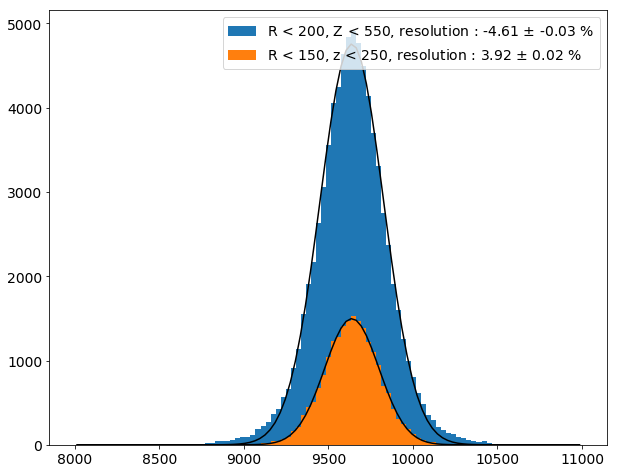

In [13]:
apt.plt_energy(E[sel]    , Ea.bins, 'R < 200, Z < 550, resolution ')
apt.plt_energy(E[sel_fid], Ea.bins, 'R < 150, z < 250, resolution ')

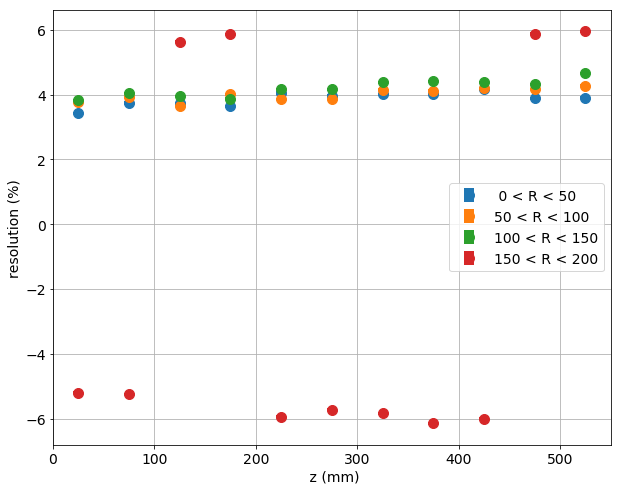

In [14]:
Ra = hst.Vaxis( (0., 201), step = 50)
Za = hst.Vaxis( (0., 551), step = 50 )
apt.plt_eresolution_zr(E, R, Z, Ea.nbins, Ea.range, Ra.bins, Za.bins)

## Dependencies of the Energy vs other variables

/Users/hernando/miniconda/envs/IC-3.6-2018-08-29/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


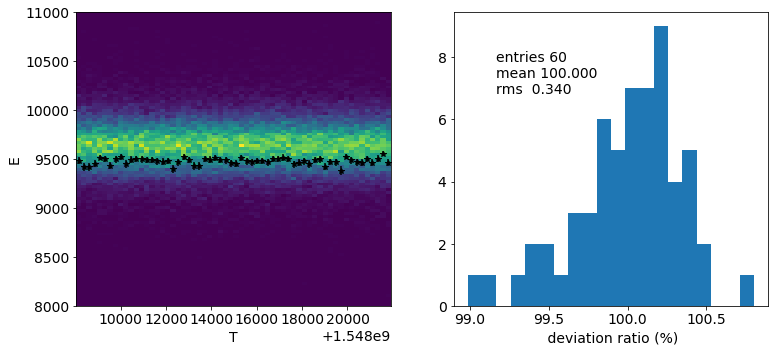

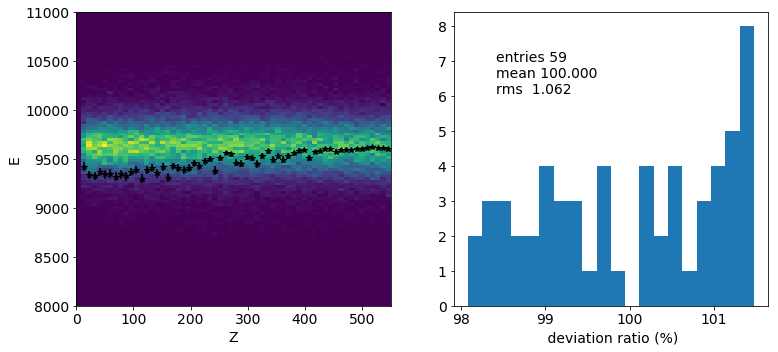

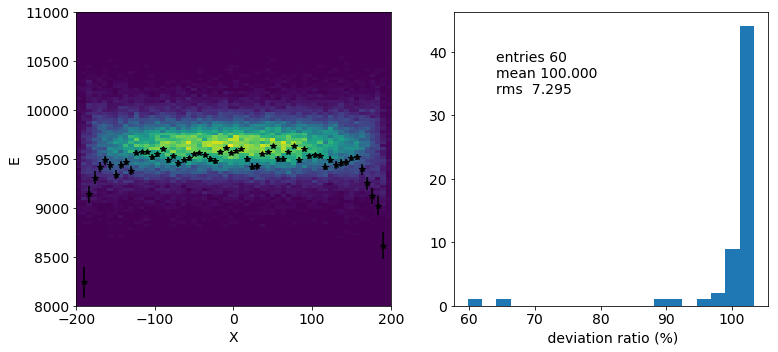

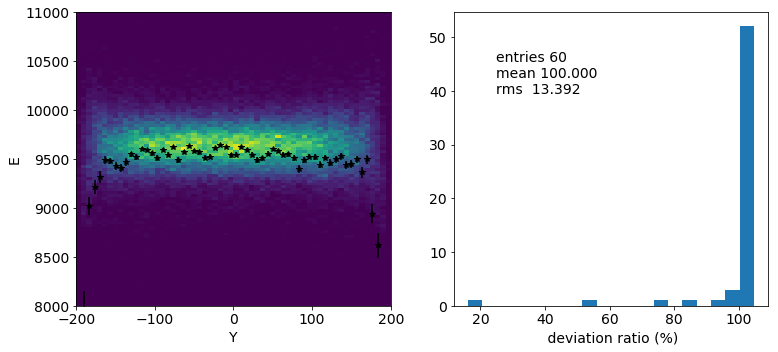

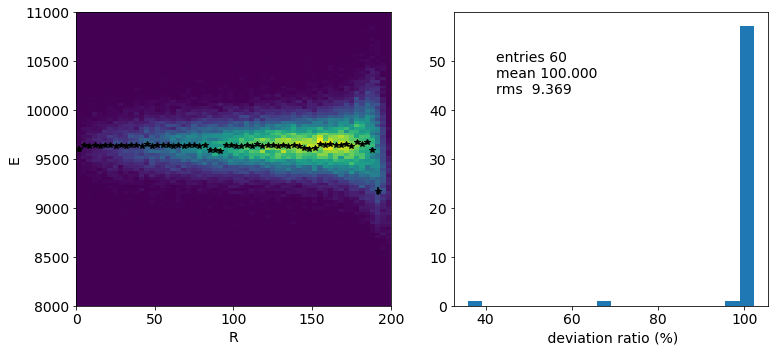

In [15]:
nbins  = 60
Trange = (T.min(), T.max())
apt.plt_v_vs_u(E[sel], T[sel], Ea.nbins, nbins, Ea.range, Trange , 'E', 'T')
apt.plt_v_vs_u(E[sel], Z[sel], Ea.nbins, nbins, Ea.range, Zrange , 'E', 'Z')
apt.plt_v_vs_u(E[sel], X[sel], Ea.nbins, nbins, Ea.range, XYrange, 'E', 'X')
apt.plt_v_vs_u(E[sel], Y[sel], Ea.nbins, nbins, Ea.range, XYrange, 'E', 'Y')
apt.plt_v_vs_u(E[sel], R[sel], Ea.nbins, nbins, Ea.range, Rrange , 'E', 'R');

## Energy vs XY

In [16]:
XYa = hst.Vaxis(XYrange, XYnbins)
E0 = np.mean(E[sel])
x, y, ee, uee = fitf.profileXY(X[sel], Y[sel], E[sel], XYnbins, XYnbins, 
                               xrange=XYrange, yrange=XYrange, std = True)
ok = ee > 0 

In [17]:
rat = 4. # per cent
Grange = (100.-rat, 100+rat)
Frange = (4., 7.)

/Users/hernando/miniconda/envs/IC-3.6-2018-08-29/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/Users/hernando/miniconda/envs/IC-3.6-2018-08-29/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6830: RuntimeWarning: invalid value encountered in greater
  h[h > cmax] = None


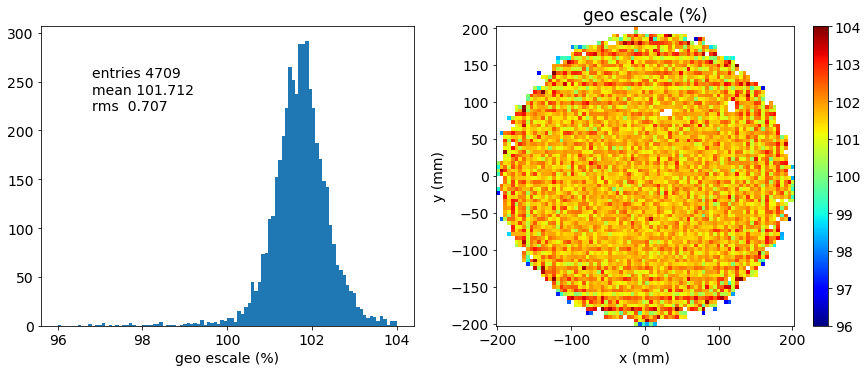

In [18]:
apt.plt_xymap(XYa.centers, XYa.centers, 100*ee/E0 , ok, Ea.nbins, Grange, 'geo escale (%)');

/Users/hernando/miniconda/envs/IC-3.6-2018-08-29/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/Users/hernando/miniconda/envs/IC-3.6-2018-08-29/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6830: RuntimeWarning: invalid value encountered in greater
  h[h > cmax] = None


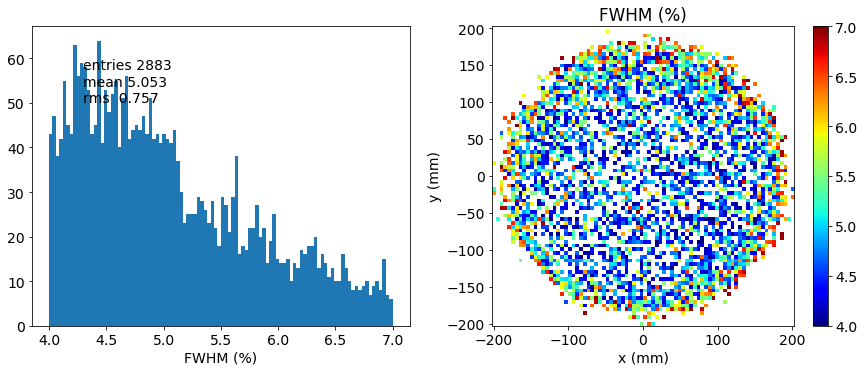

In [19]:
apt.plt_xymap(XYa.centers, XYa.centers, 100*2.355*uee/E0, ok, Ea.nbins, Frange, 'FWHM (%)');

## Energy scale and resolution vs XY in Z-slices

In [20]:
vs, vus, voks = akr.xymap_vprofile_zslice(E[sel], X[sel], Y[sel], Z[sel], Za.bins, XYnbins, XYrange)

/Users/hernando/miniconda/envs/IC-3.6-2018-08-29/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/Users/hernando/miniconda/envs/IC-3.6-2018-08-29/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6830: RuntimeWarning: invalid value encountered in greater
  h[h > cmax] = None


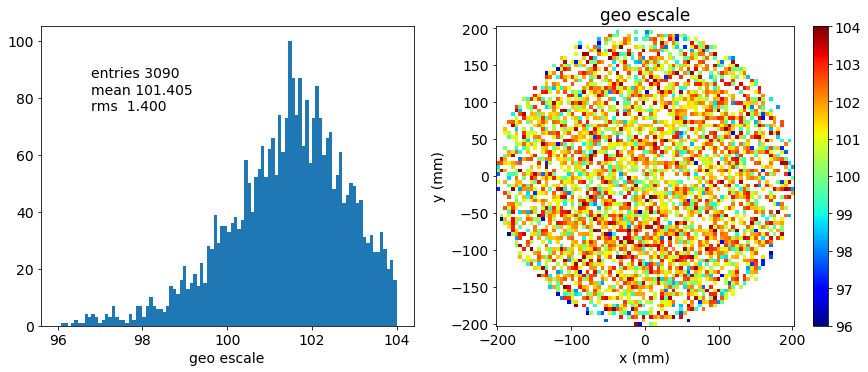

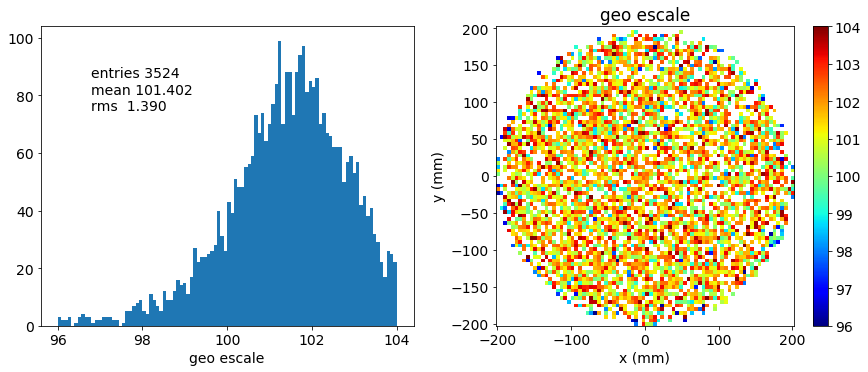

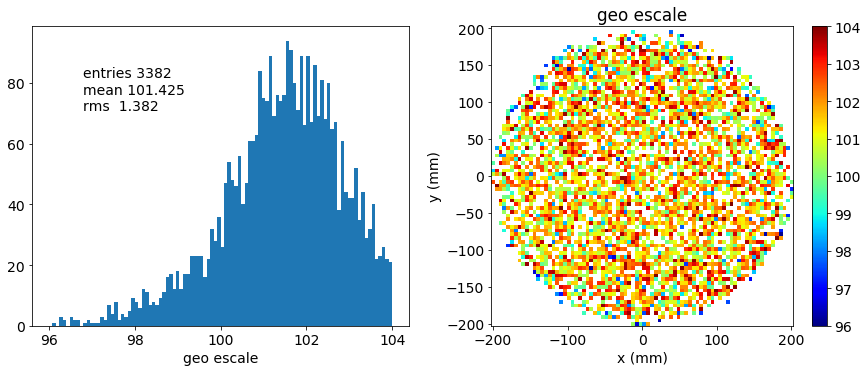

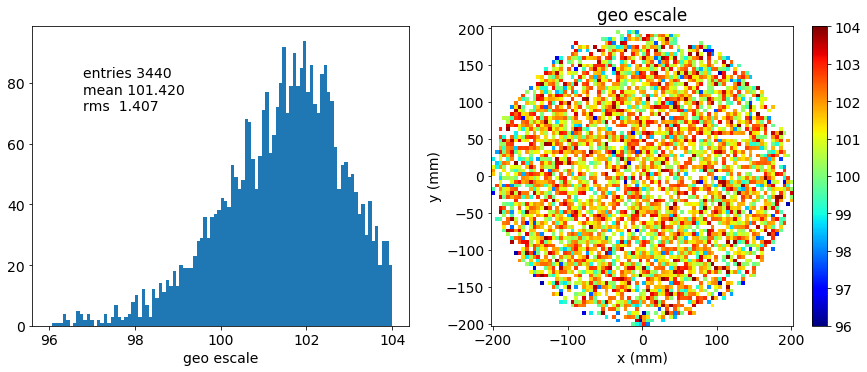

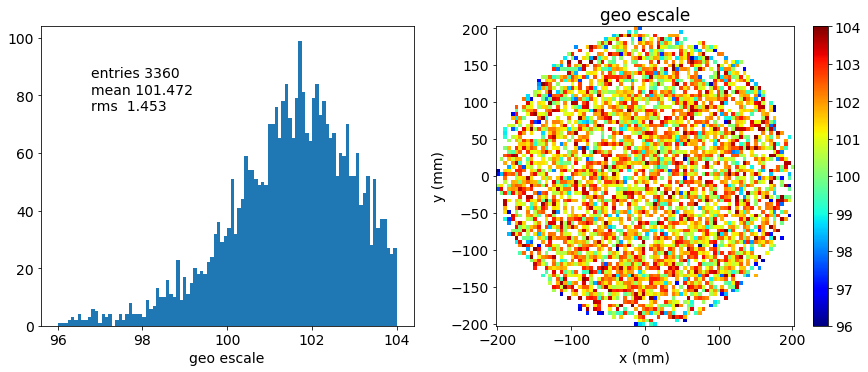

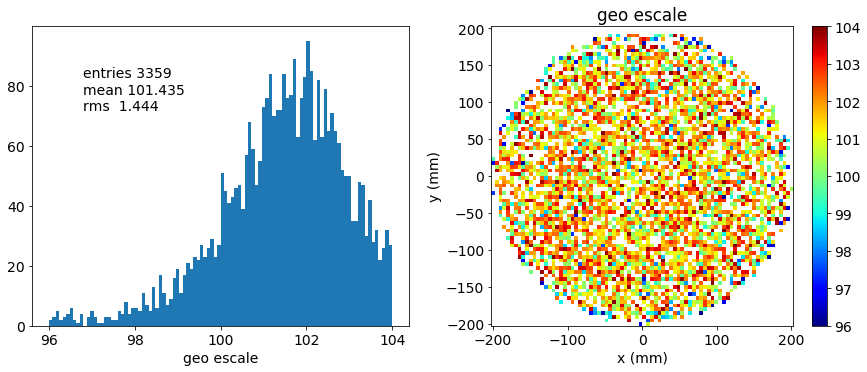

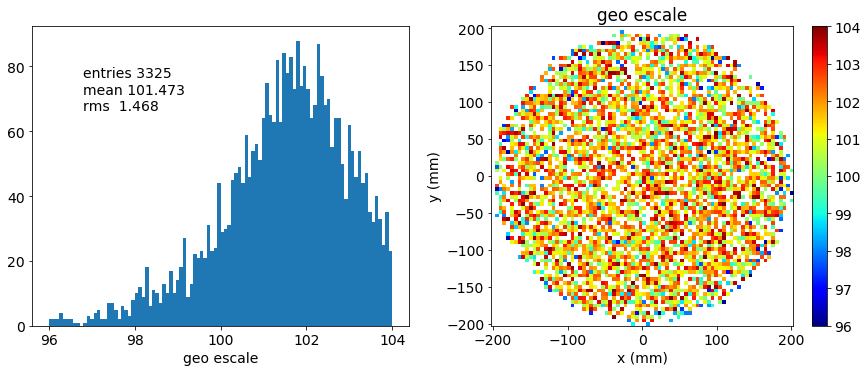

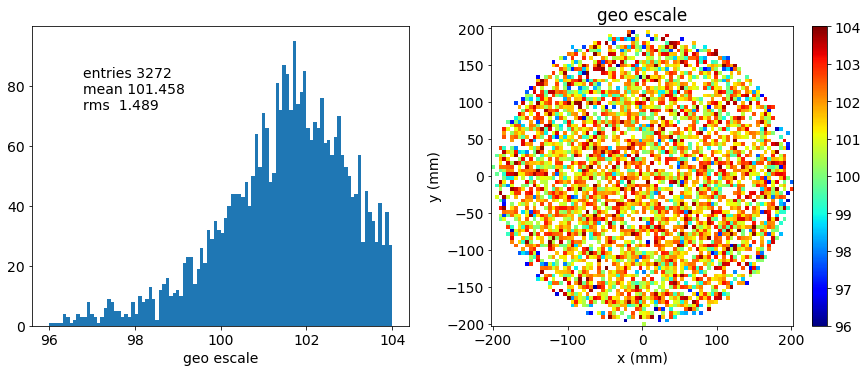

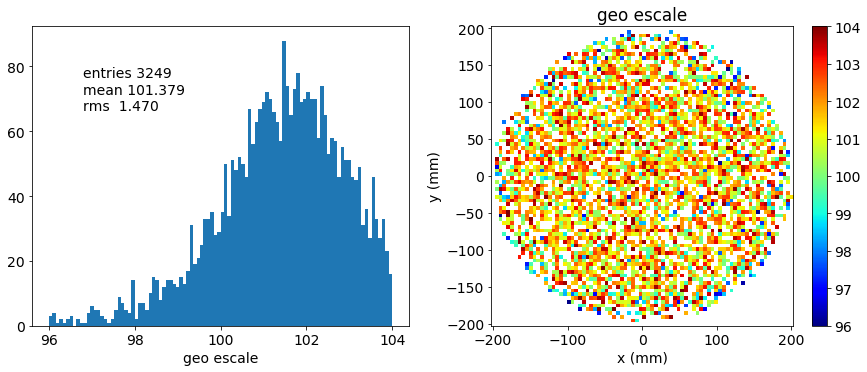

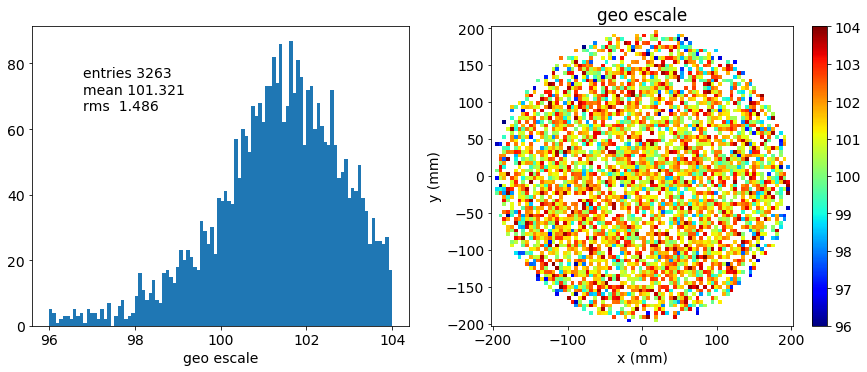

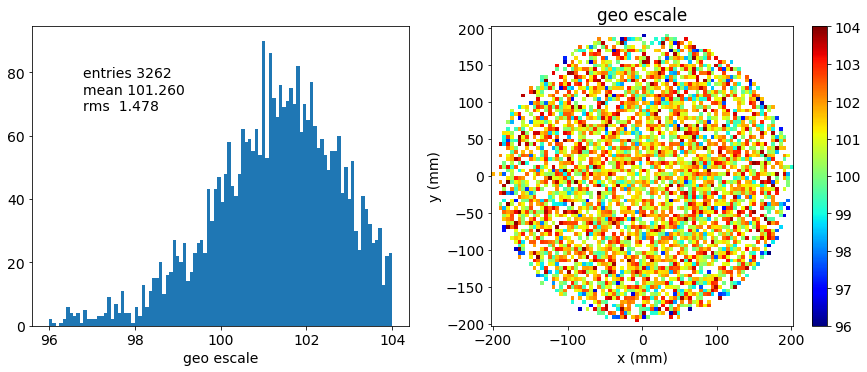

In [21]:
rat = 4. # per cent
Grange = (100.-rat, 100+rat)
label = 'plots/run'+str(run_number)+'geo'
for i in range(Za.nbins):
    apt.plt_xymap(XYa.centers, XYa.centers, 100*vs[i]/E0, voks[i], Ea.nbins, Grange, 'geo escale')
    if (make_movie):
        fig = plt.gcf()
        fig.savefig(label+str(i)+'.png')
if (make_movie):
    mv.movie(label, Za.nbins)

/Users/hernando/miniconda/envs/IC-3.6-2018-08-29/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/Users/hernando/miniconda/envs/IC-3.6-2018-08-29/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6830: RuntimeWarning: invalid value encountered in greater
  h[h > cmax] = None


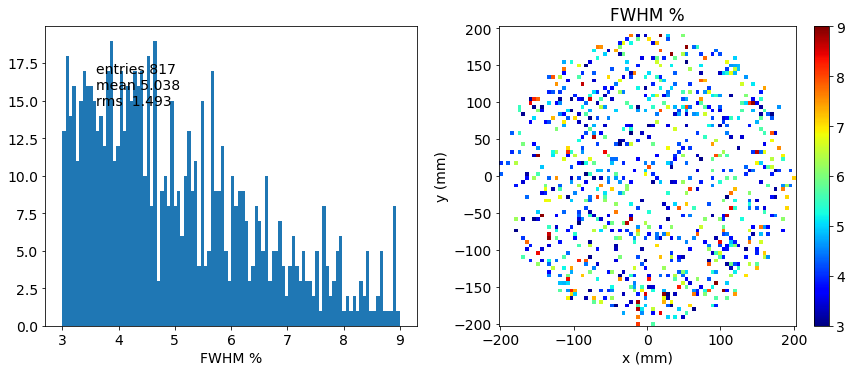

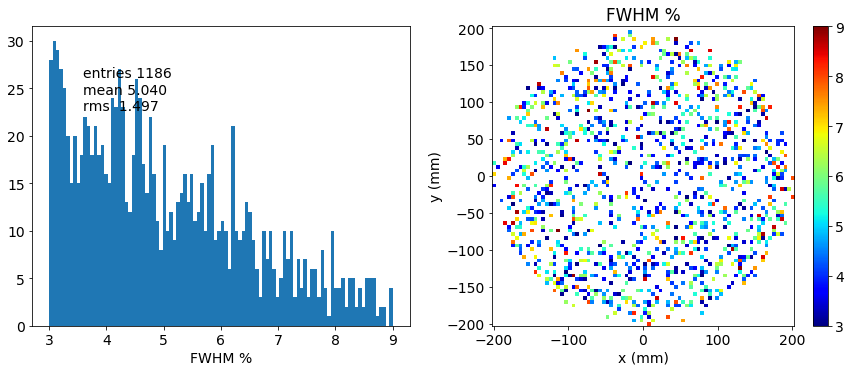

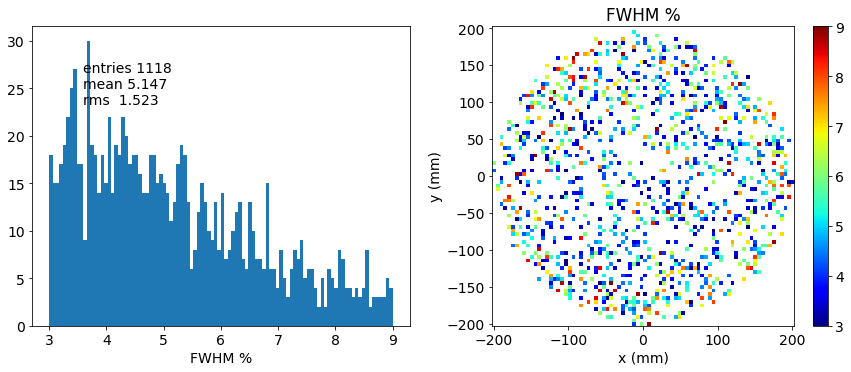

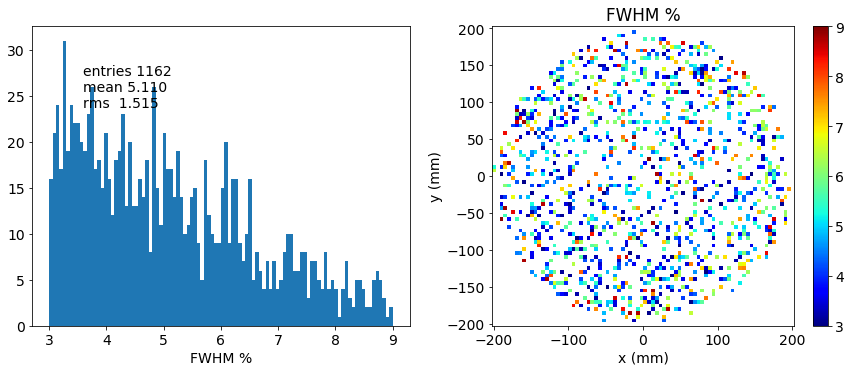

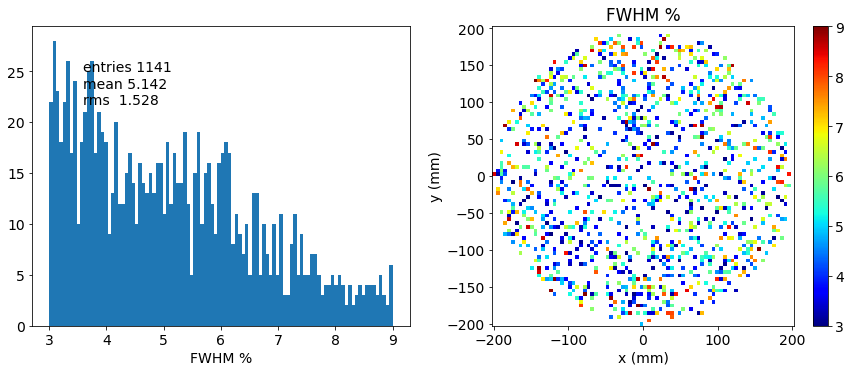

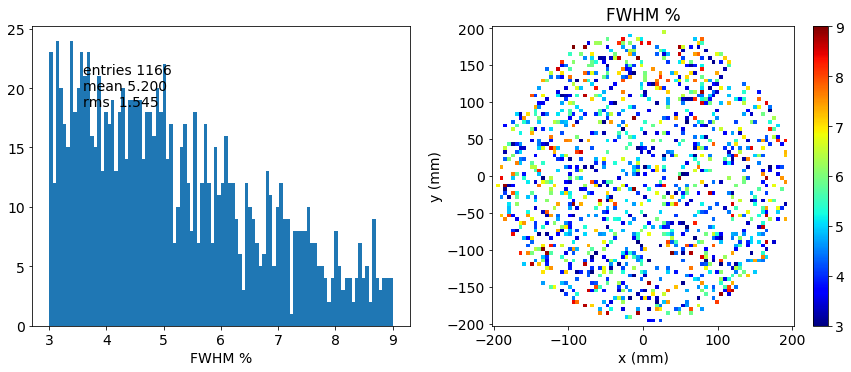

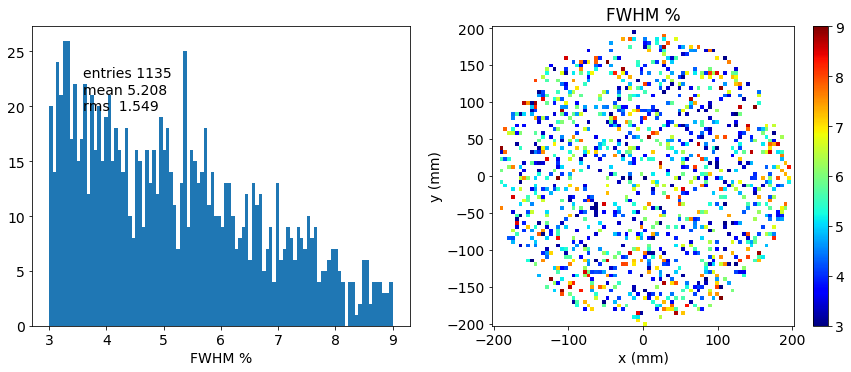

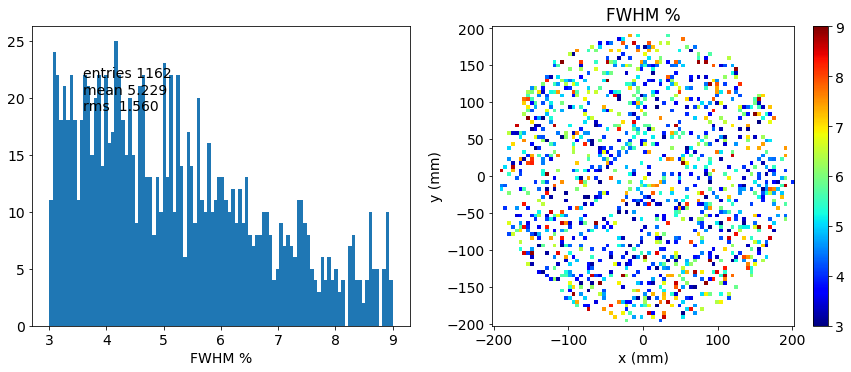

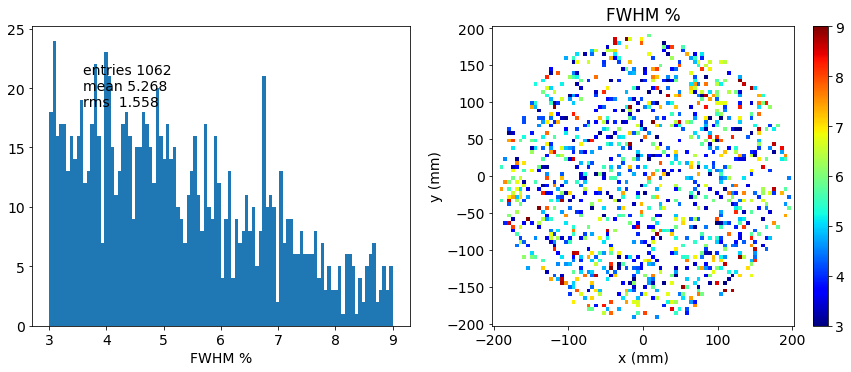

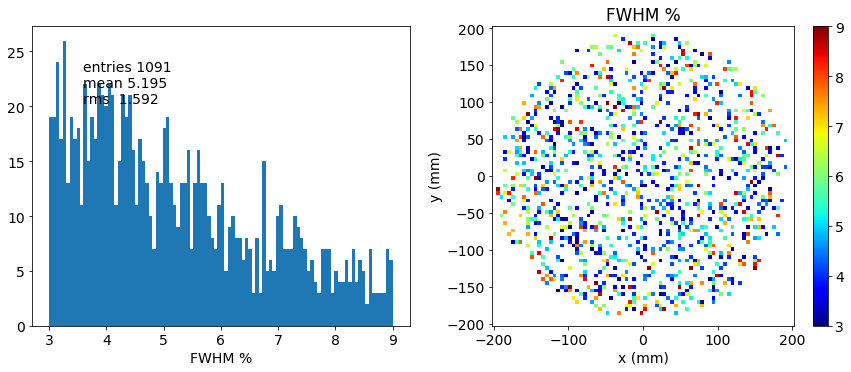

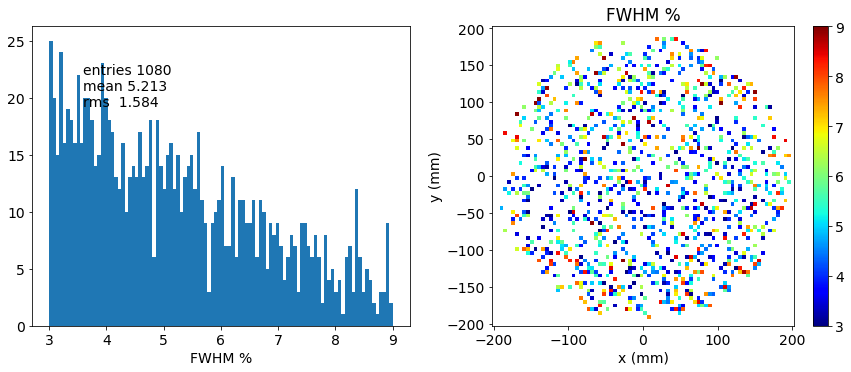

In [22]:
Frange = (3., 9)
label = 'plots/run'+str(run_number)+'eres'
for i in range(Za.nbins):
    apt.plt_xymap(XYa.centers, XYa.centers, 100*2.355*vus[i]/E0, voks[i], Ea.nbins, Frange, 'FWHM %')
    if (make_movie):
        fig = plt.gcf()
        fig.savefig(label+str(i)+'.png')
if (make_movie):
    mv.movie(label, Za.nbins)

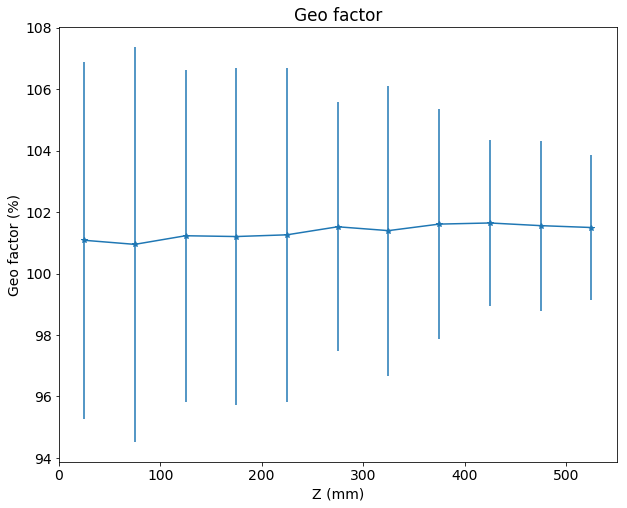

In [23]:
vals = [akr.xymap_mean_std(100.*vi/E0, viok) for vi, viok in zip(vs, voks)]
ms, us = [ival[0] for ival in vals], [ival[1] for ival in vals]
plt.errorbar(Za.centers, ms, us, fmt='-*');
plt.xlabel('Z (mm)'); plt.ylabel('Geo factor (%)'); plt.title('Geo factor');

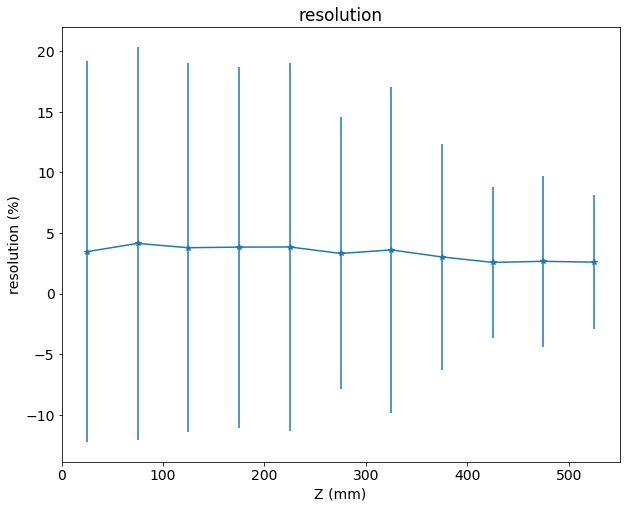

In [24]:
vals = [akr.xymap_mean_std(100.*2.355*vi/E0, viok) for vi, viok in zip(vus, voks)]
ms, us = [ival[0] for ival in vals], [ival[1] for ival in vals]
plt.errorbar(Za.centers, ms, us, fmt='-*');
plt.xlabel('Z (mm)'); plt.ylabel('resolution (%)'); plt.title('resolution');

In [25]:
print('Done!')

Done!
